## Plotting Notebook for SFNO Model Output

### 1. Imports and Setup
This cell imports necessary libraries and ensures custom modules from the project root can be loaded.

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt


import json
import os
import sys

if os.path.basename(os.getcwd()) == 'notebooks':
    project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if project_root_path not in sys.path:
        sys.path.append(project_root_path)
    os.chdir(project_root_path)
    print(f"Changed CWD to: {os.getcwd()}")
else:
    print(f"Current CWD is: {os.getcwd()} (assumed to be project_root)")

from model import SFNO 
from torch_harmonics.examples.sfno import PdeDataset 

plt.style.use('notebooks/science.mplstyle')


Current CWD is: /Users/imalsky/Desktop/SFNO (assumed to be project_root)


### 2. Load Configuration and Set Device

In [8]:
config_path = 'inputs/config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

model_p = config['model_params']
data_p = config['dataset_params']
cmap = config['plot_cmap']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### 3. Re-initialize Solver
The solver object from `PdeDataset` is needed for its `plot_griddata` method.

In [9]:
dt_hours = data_p['dt_hours']
dt_solver_seconds = data_p['dt_solver_seconds']
dt_notebook = dt_hours * 3600
nsteps_notebook = dt_notebook // dt_solver_seconds

dataset_for_solver = PdeDataset(
    dt=dt_notebook, 
    nsteps=nsteps_notebook, 
    dims=tuple(data_p['dims']), 
    device=torch.device('cpu'),
    normalize=True 
)
solver = dataset_for_solver.solver.to(torch.device('cpu'))

print("Solver initialized for plotting.")

Solver initialized for plotting.


### 4. Load the Trained Model

In [10]:
nlat_model, nlon_model = data_p['dims']

loaded_model = SFNO(
    img_size=(nlat_model, nlon_model),
    grid=model_p['grid'],
    num_layers=model_p['num_layers'],
    scale_factor=model_p['scale_factor'],
    embed_dim=model_p['embed_dim'],
    big_skip=model_p['big_skip'],
    pos_embed=model_p['pos_embed'],
    use_mlp=model_p['use_mlp'],
    normalization_layer=model_p['normalization_layer']
)

model_save_path = 'model/final_model.pth'
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_model.to(device)
loaded_model.eval()

print(f"Model loaded from {model_save_path} and in eval mode.")

Model loaded from model/final_model.pth and in eval mode.


### 5. Load Saved Sample Data
This data was generated and saved by `main.py`.

In [11]:
sample_data_path = 'data/sample_inference_data.pt'
saved_data = torch.load(sample_data_path, map_location='cpu') 

inp = saved_data['input'] 
tar = saved_data['target'] 
out_saved = saved_data['prediction']

print("Sample inference data loaded.")
print(f"Input shape: {inp.shape}, Target shape: {tar.shape}, Saved Prediction shape: {out_saved.shape}")

out = out_saved

Sample inference data loaded.
Input shape: torch.Size([4, 3, 256, 512]), Target shape: torch.Size([4, 3, 256, 512]), Saved Prediction shape: torch.Size([4, 3, 256, 512])


### 6. Plotting

Plotting sample 0, channel 2 using cmap: twilight_shifted


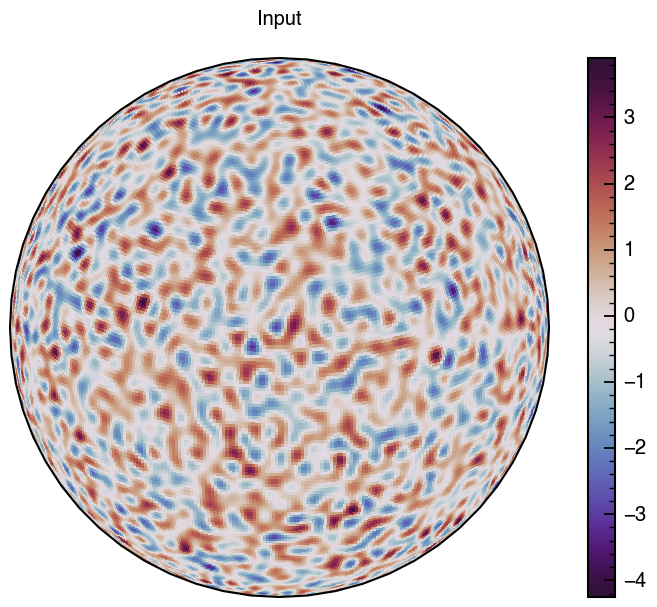

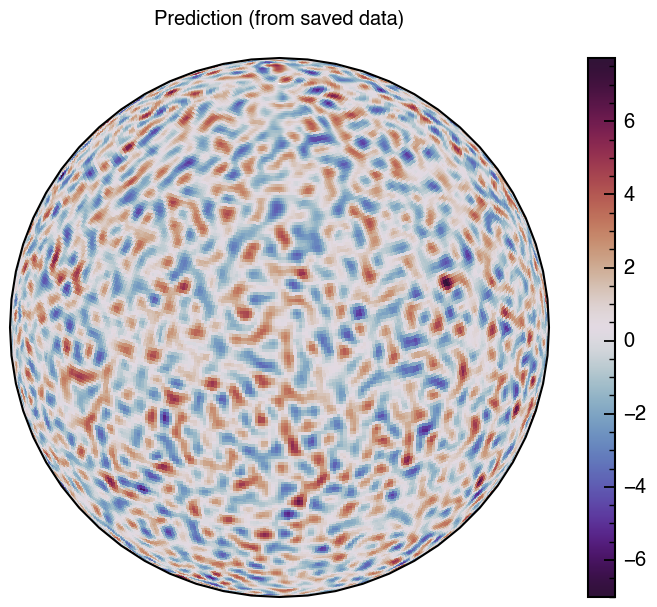

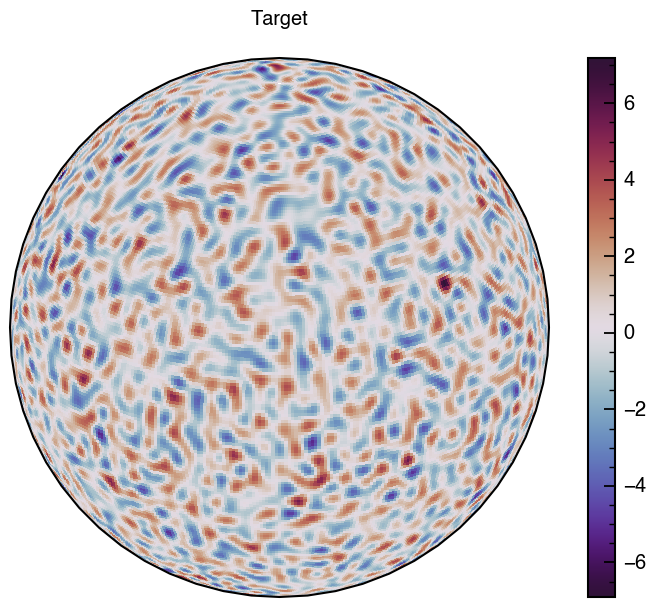

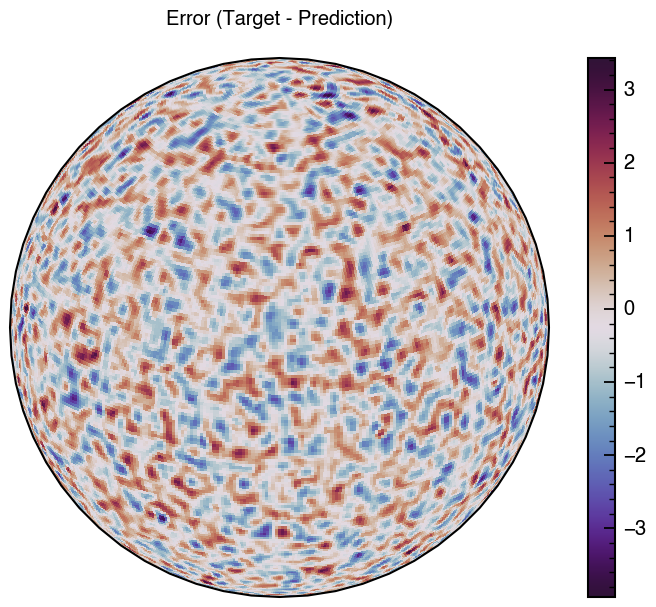

In [12]:
s = 0 
ch = 2

if inp.ndim < 2 or inp.shape[1] <= ch:
    print(f"Warning: Channel {ch} is out of bounds for data with shape {inp.shape}. Plotting channel 0.")
    ch = 0
    if inp.ndim < 2 or inp.shape[1] == 0:
        raise ValueError("Data has no channels or insufficient dimensions to plot.")

print(f"Plotting sample {s}, channel {ch} using cmap: {cmap}")

# Plot Input
fig_input = plt.figure(figsize=(10, 7))
im_input = solver.plot_griddata(inp[s, ch].cpu(), fig_input, projection='3d', title='Input')
plt.colorbar(im_input)
plt.show()

# Plot Prediction
fig_pred = plt.figure(figsize=(10, 7))
im_pred = solver.plot_griddata(out[s, ch].cpu(), fig_pred, projection='3d', title='Prediction (from saved data)')
plt.colorbar(im_pred)
plt.show()

# Plot Target
fig_target = plt.figure(figsize=(10, 7))
im_target = solver.plot_griddata(tar[s, ch].cpu(), fig_target, projection='3d', title='Target')
plt.colorbar(im_target)
plt.show()

# Plot Error
fig_error = plt.figure(figsize=(10, 7))
im_error = solver.plot_griddata((tar[s, ch] - out[s, ch]).cpu(), fig_error, projection='3d', title='Error (Target - Prediction)')
plt.colorbar(im_error)
plt.show()